In [41]:
import wrds
db=wrds.Connection(wrds_username='hlanfran')
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.api import add_constant
import statsmodels.regression.linear_model as lm

Loading library list...
Done


In [15]:
import numpy as np
import datetime
import pandas as pd
import datetime

In [16]:
# get risk-free rate see http://www.crsp.com/files/treasury_guide_0.pdf
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1990-01-01'"
            "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#use own index instead
# get index returns
data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1990-01-01'"
            "and date<='2021-12-31'", date_cols=['date'])


# get stock returns
crsp_m = db.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2021'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
msf=crsp_m.drop(['shrcd','exchcd'],axis=1)
del(crsp_m) 

msf['prc']=np.abs(msf['prc'])

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

#variables
msf['permno'] = msf['permno'].astype(int)
msf['prc']=np.abs(msf['prc'])
msf["market_cap"] = msf['prc'] * msf["shrout"]
msf['const'] = 1
msf.sort_values(['permno','date'])

#shift by 1
msf['market_cap_lagged']= msf.groupby('permno')['market_cap'].shift(1).to_frame()

obs=msf[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
msf = pd.merge(msf, obs, how='left', left_on=['permno'],right_on=['permno'])



#################################
# Compute excess returns
#################################
data_index = pd.merge(data_index, Rf, how='left', left_on=['date'],right_on='date')
data_index['mprem']=(data_index['vwretd']-data_index['rf'])
data = pd.merge(msf, data_index, how='left', left_on=['date'],right_on='date')
data['exret']=data['ret']-data['rf']



print('duplicates in data on returns?')
print(data.duplicated(subset=['date','permno']).sum(),'\n')

print(' How many obervations do we have in a month?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))

print('\n Let us limit our attention to stocks we observe often enough...')


duplicates in data on returns?
0 

 How many obervations do we have in a month?
max: 2462
min: 1370

 How often do we observe a given stock?
max: 384
min: 1

 Let us limit our attention to stocks we observe often enough...


In [17]:
data=data[data['obs']==384]

# A

In [20]:
precise_date = data[data["date"] == "2021-12-31"]
precise_date = precise_date.sort_values("market_cap",ascending=False)
precise_date["buckets"] = pd.qcut(precise_date["market_cap"],10, labels=range(1,11))

In [21]:
data["buckets"] = data["permno"].map(lambda x: precise_date[precise_date["permno"] == x]["buckets"].values[0])
data["market_cap_2021"] = data["permno"].map(lambda x: precise_date[precise_date["permno"] == x]["market_cap"].values[0])


In [22]:
covariances=data.groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar'})

mvar=data.groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

data = pd.merge(data, covariances, how='left', left_on=['permno'],right_on='permno')
data = pd.merge(data, mvar, how='left', left_on=['permno'],right_on='permno')

# cumpute the betas
data['beta']=data['covar']/data['varm']


### Equal weighted

In [28]:
data = data.set_index('date')  

In [29]:
ewrets = data.groupby(['buckets','date']).apply(wavg, 'ret','const').to_frame().reset_index().rename(columns={0: 'ewret'})

ewbetas = data.groupby(['buckets']).apply(wavg, 'beta','const').to_frame().reset_index().rename(columns={0: 'beta'})

ewsize = data.groupby(['buckets']).apply(wavg, 'market_cap_2021','const').to_frame().reset_index().rename(columns={0: 'size'})

In [30]:
avgewrets = ewrets.groupby(['buckets']).mean().reset_index()

# convert data back to what we had before
data = data.reset_index()

### Value weighted

In [36]:
data=data.set_index('date')  

vwrets=data.groupby(['buckets','date']).apply(wavg, 'ret','market_cap_lagged').to_frame().reset_index().rename(columns={0: 'vwret'})

vwdata=pd.merge(vwrets, Rf, how='left', left_on=['date'],right_on='date')
vwdata=pd.merge(vwrets, data_index, how='left', left_on=['date'],right_on='date')

vwdata['vwexret']=vwdata['vwret']-vwdata['rf']

covariances=vwdata.groupby('buckets')['vwexret'].cov(vwdata['mprem']).to_frame().reset_index().rename(columns={'vwexret': 'covar'})

mvar=vwdata.groupby('buckets')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

vwbetas = pd.merge(covariances, mvar, how='left', left_on=['buckets'],right_on='buckets')

# cumpute the betas
vwbetas['beta']=vwbetas['covar']/vwbetas['varm']

avgvwrets=vwrets.groupby(['buckets']).mean().reset_index()

data=data.reset_index()


 (a) betas and returns: whole sample and equally-weighted returns:


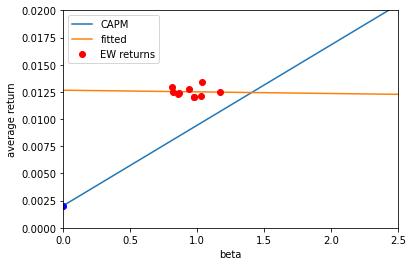

The market risk premium is  0.0074 .

The actual slope is  -0.00015 .



In [37]:
regdata = pd.merge(avgewrets, ewbetas, how='left', left_on=['buckets'],right_on='buckets')

result1 = sm.ols(formula="ewret ~ beta", data=regdata).fit()

regdata = pd.merge(avgvwrets, vwbetas, how='left', left_on=['buckets'],right_on='buckets')

result2 = sm.ols(formula="vwret ~ beta", data=regdata).fit()



#make plots of returns vs. beta
R0=Rf[Rf['date']>'1990-01-31']['rf'].mean()
MP=data_index[data_index['date']>'1990-01-31']['mprem'].values.mean()

beta_values = np.linspace(0,2.5,100)


# first plot
CAPM_line = R0+MP*beta_values
fitted_line=result1.params.values[0]+result1.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewbetas['beta'].values,avgewrets['ewret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2.5)
plt.ylim(0, 0.02)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')

plt.savefig('FS_VW_plot.png', format='png')
plt.show()
print('The market risk premium is ',np.round(MP,5) ,'.\n')
print('The actual slope is ',np.round(result1.params.values[1],5),'.\n')

# B

## Equal weighted returns

In [60]:
df_ew = pd.DataFrame(data=np.empty((10, 5)), columns=['exret','alpha','p-value alpha', 'beta','p-value beta'])


for i in range(1,11): 

    # model specification
    y = ewrets[ewrets['buckets']==i]['ewret'].values-Rf['rf'].values
    x = data_index['mprem'].values
    X = add_constant(x)

    model = lm.OLS(endog=y,exog=X,missing='drop')
    results = model.fit()
    
    df_ew.loc[i] = [ewrets[ewrets['buckets']==i]['ewret'].mean()-R0,results.params[0],results.pvalues[0],results.params[1],results.pvalues[1]]


display(df_ew.iloc[1:,:])


,exret,alpha,p-value alpha,beta,p-value beta
1,0.010005,0.003009,0.133427,0.973050,2.622868e-67
2,0.010475,0.002086,0.289252,1.167176,5.252648e-87
3,0.010047,0.002665,0.090850,1.026911,1.644745e-97
4,0.010740,0.003975,0.012311,0.940974,2.681919e-87
5,0.011409,0.003973,0.006955,1.034367,1.274757e-106
6,0.009966,0.002969,0.027192,0.973263,4.884706e-110
7,0.010482,0.004578,0.000106,0.821068,5.282440e-106
8,0.010394,0.004198,0.000059,0.861697,3.359684e-127
9,0.010946,0.005121,0.000021,0.809871,3.143806e-102
10,0.010243,0.004087,0.000075,0.856130,6.225011e-128


## Value weighted returns

In [61]:
df_vw = pd.DataFrame(data=np.empty((10, 5)), columns=['exret','alpha','p-value alpha', 'beta','p-value beta'])


for i in range(1,11): 

    # model specification
    y = vwrets[vwrets['buckets']==i]['vwret'].values-Rf['rf'].values
    x = data_index['mprem'].values
    X = add_constant(x)

    model = lm.OLS(endog=y,exog=X,missing='drop')
    results = model.fit()
    
    df_vw.loc[i] = [vwrets[vwrets['buckets']==i]['vwret'].mean()-R0,results.params[0],results.pvalues[0],results.params[1],results.pvalues[1]]

display(df_vw.iloc[1:,:])

,exret,alpha,p-value alpha,beta,p-value beta
1,0.002332,-0.005998,0.004883,1.158973,1.555331e-78
2,0.002861,-0.004808,0.012427,1.066910,2.045865e-80
3,0.004960,-0.002633,0.086564,1.056364,1.032998e-103
4,0.005456,-0.001343,0.380383,0.919310,6.092616e-88
5,0.006567,-0.000890,0.515098,1.037303,1.875132e-115
6,0.005992,-0.001254,0.338937,1.007883,4.917833e-117
7,0.005926,0.000381,0.740671,0.770918,1.845309e-100
8,0.006406,-0.000399,0.659384,0.946488,6.152294e-158
9,0.007932,0.001597,0.148376,0.880956,9.762537e-122
10,0.007535,0.002005,0.058250,0.768874,2.560148e-110


# C

In [62]:
data

,date,permno,ret,shrout,prc,market_cap,const,market_cap_lagged,obs,vwretd,rf,mprem,exret,buckets,market_cap_2021,covar,varm,beta
0,1990-01-31,10516,-0.134054,281065.0,20.000000,5.621300e+06,1,NaN,384,-0.070114,0.006390,-0.076503,-0.140444,8,3.781262e+07,0.001098,0.001888,0.581356
1,1990-02-28,10516,0.050000,281065.0,21.000000,5.902365e+06,1,5.621300e+06,384,0.014900,0.006441,0.008459,0.043559,8,3.781262e+07,0.001098,0.001888,0.581356
2,1990-03-30,10516,0.083333,283801.0,22.750000,6.456473e+06,1,5.902365e+06,384,0.024148,0.006688,0.017460,0.076645,8,3.781262e+07,0.001098,0.001888,0.581356
3,1990-04-30,10516,0.034066,283801.0,23.500000,6.669324e+06,1,6.456473e+06,384,-0.028283,0.006283,-0.034567,0.027782,8,3.781262e+07,0.001098,0.001888,0.581356
4,1990-05-31,10516,0.127660,283801.0,26.500000,7.520726e+06,1,6.669324e+06,384,0.088935,0.006132,0.082803,0.121528,8,3.781262e+07,0.001098,0.001888,0.581356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126715,2021-08-31,85914,0.037027,245964.0,116.510002,2.865727e+07,1,2.814064e+07,384,0.027147,0.000034,0.027113,0.036993,7,2.444100e+07,0.002604,0.001888,1.378981
126716,2021-09-30,85914,-0.086688,245964.0,105.709999,2.600085e+07,1,2.865727e+07,384,-0.042243,0.000038,-0.042281,-0.086726,7,2.444100e+07,0.002604,0.001888,1.378981
126717,2021-10-29,85914,0.156371,245964.0,122.239998,3.006664e+07,1,2.600085e+07,384,0.064657,0.000042,0.064614,0.156329,7,2.444100e+07,0.002604,0.001888,1.378981
126718,2021-11-30,85914,-0.125818,245964.0,106.860001,2.628371e+07,1,3.006664e+07,384,-0.018347,0.000068,-0.018414,-0.125886,7,2.444100e+07,0.002604,0.001888,1.378981


In [68]:
for date in data["date"].unique()[1:]:
    precise_date = data[data["date"] == date]
    precise_date = precise_date.sort_values("market_cap_lagged",ascending=False)
    precise_date["buckets"] = pd.qcut(precise_date["market_cap"],10, labels=range(1,11))
    data["buckets_lagged2"] = data[data["date"] == date]["permno"].map(lambda x: precise_date[precise_date["permno"] == x]["buckets"].values[0])
    break

In [70]:
data[data["date"] == "1990-01-31"].head(50)

,date,permno,ret,shrout,prc,market_cap,const,market_cap_lagged,obs,vwretd,rf,mprem,exret,buckets,market_cap_2021,covar,varm,beta,buckets_lagged,buckets_lagged2
0,1990-01-31,10516,-0.134054,281065.0,20.000,5.621300e+06,1,NaN,384,-0.070114,0.00639,-0.076503,-0.140444,8,3.781262e+07,0.001098,0.001888,0.581356,9,NaN
384,1990-01-31,10890,-0.076271,158657.0,13.625,2.161702e+06,1,NaN,384,-0.070114,0.00639,-0.076503,-0.082661,2,1.381317e+06,0.003992,0.001888,2.113845,7,NaN
385,1990-01-31,10866,-0.152074,17421.0,23.000,4.006830e+05,1,NaN,384,-0.070114,0.00639,-0.076503,-0.158463,2,8.638812e+05,0.002754,0.001888,1.458370,4,NaN
1035,1990-01-31,10874,-0.107257,87958.0,12.500,1.099475e+06,1,NaN,384,-0.070114,0.00639,-0.076503,-0.113646,5,7.765780e+06,0.003407,0.001888,1.803930,6,NaN
1536,1990-01-31,11308,-0.108414,341315.0,68.875,2.350807e+07,1,NaN,384,-0.070114,0.00639,-0.076503,-0.114804,10,2.557872e+08,0.001097,0.001888,0.580877,10,NaN
1920,1990-01-31,11404,-0.064378,228130.0,27.250,6.216542e+06,1,NaN,384,-0.070114,0.00639,-0.076503,-0.070767,8,3.018186e+07,0.000235,0.001888,0.124484,9,NaN
2304,1990-01-31,11674,-0.024631,146819.0,24.750,3.633770e+06,1,NaN,384,-0.070114,0.00639,-0.076503,-0.031020,7,2.315813e+07,0.000638,0.001888,0.337782,8,NaN
2688,1990-01-31,11731,-0.079470,26690.0,17.375,4.637388e+05,1,NaN,384,-0.070114,0.00639,-0.076503,-0.085860,3,2.864011e+06,0.002387,0.001888,1.263816,4,NaN
3072,1990-01-31,11850,-0.060000,1251632.0,47.000,5.882670e+07,1,NaN,384,-0.070114,0.00639,-0.076503,-0.066390,10,2.590520e+08,0.001219,0.001888,0.645249,10,NaN
3456,1990-01-31,11891,-0.064000,25166.0,14.625,3.680528e+05,1,NaN,384,-0.070114,0.00639,-0.076503,-0.070390,7,2.104693e+07,0.003557,0.001888,1.883337,4,NaN


In [71]:
data["date"].unique()

array(['1990-01-31T00:00:00.000000000', '1990-02-28T00:00:00.000000000',
       '1990-03-30T00:00:00.000000000', '1990-04-30T00:00:00.000000000',
       '1990-05-31T00:00:00.000000000', '1990-06-29T00:00:00.000000000',
       '1990-07-31T00:00:00.000000000', '1990-08-31T00:00:00.000000000',
       '1990-09-28T00:00:00.000000000', '1990-10-31T00:00:00.000000000',
       '1990-11-30T00:00:00.000000000', '1990-12-31T00:00:00.000000000',
       '1991-01-31T00:00:00.000000000', '1991-02-28T00:00:00.000000000',
       '1991-03-28T00:00:00.000000000', '1991-04-30T00:00:00.000000000',
       '1991-05-31T00:00:00.000000000', '1991-06-28T00:00:00.000000000',
       '1991-07-31T00:00:00.000000000', '1991-08-30T00:00:00.000000000',
       '1991-09-30T00:00:00.000000000', '1991-10-31T00:00:00.000000000',
       '1991-11-29T00:00:00.000000000', '1991-12-31T00:00:00.000000000',
       '1992-01-31T00:00:00.000000000', '1992-02-28T00:00:00.000000000',
       '1992-03-31T00:00:00.000000000', '1992-04-30